In [1]:
"""Import libraries, read data""" 

import itertools
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind, norm
import statsmodels.formula.api as smf
import statsmodels.api as sm

df = pd.read_csv('data/datasci_takehome.csv')
df['performance_ratio'] = df['correctedkwh'] / df['expectedkwh']

all_vintages = df['vintage'].unique()

<center><h1>kWh Analytics Project</h1></center>

<center><h3>Viraj Navkal</h3></center>

<h2>Introduction</h2>
I found that vintage C has a significantly worse performance ratio than vintages A and B, but I could not find strong evidence that vintages A and B are different.

I have separated my analysis into three sections:
1. The _Exploration_ section explains the preliminary analysis I did, to form hypotheses and get a sense of how the data looked.
2. The _Testing all variables simultaneously_ section describes the method I used to reach my conclusion.
3. The _Remarks_ section at the end has some notes about my approach and possible alternatives.

<h2>1. Exploration</h2>

<h4>$t$-test</h4>

One of the first things I checked was the two-sample $t$-test values for each pair of vintages.  They suggested that vintages A and B are not too different from each other, but vintage C is different from both.

In [2]:
for vintage_0, vintage_1 in itertools.combinations(all_vintages, 2):
    t_stat_result = ttest_ind(
        df[df['vintage']==vintage_0]['performance_ratio'],
        df[df['vintage']==vintage_1]['performance_ratio']
    )
    print('p-value of 2-sample t-statistic comparing vintage {0} and {1} is {2}'.
          format(vintage_0, vintage_1, t_stat_result.pvalue))

p-value of 2-sample t-statistic comparing vintage A and B is 0.30858421813302167
p-value of 2-sample t-statistic comparing vintage A and C is 0.0006631157685030222
p-value of 2-sample t-statistic comparing vintage B and C is 1.455243512792677e-06


<h4>Effect of month</h4>

The $t$-statistic values could be quite misleading if the `month` and `vintage` variables are not independent.  For example, vintage C might appear different from the other vintages entirely because it was observed during different times of the year.  And indeed, the two variables are dependent -- vintages A and B were observed predominantly in the later months, as the following plot shows.

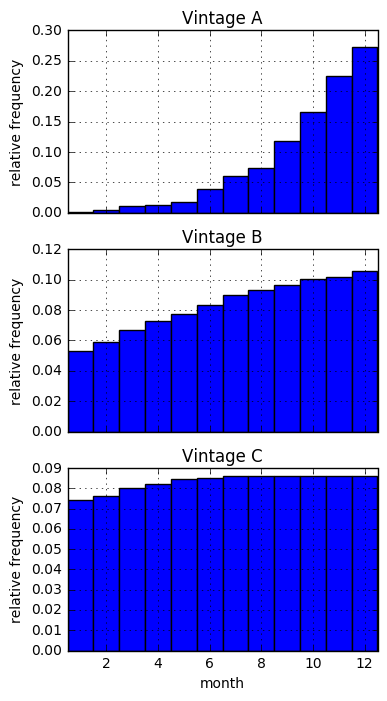

In [3]:
fig, axes = plt.subplots(3, 1, sharex='col', figsize=(4, 8))
for i, vintage in enumerate(all_vintages):
    df[df['vintage']==vintage]['month'].hist(bins=range(14), ax=axes[i], normed=True, align='left')
    axes[i].set_title('Vintage ' + vintage)
    axes[i].set_ylabel('relative frequency')
axes[-1].set_xlim((.5, 12.5))
axes[-1].set_xlabel('month')

plt.show()

So it's important not to ignore `month` when comparing the performance of the three vintages.

<h2>2. Testing all variables simultaneously</h2>

In order to compare the different vintages' performances in a way that accounts for seasonal differences, I trained a model that included both `vintage` and `month` variables.  The model I chose to use is a GLM model with gamma distribution for residuals, which is a reasonable choice when the response variable is nonnegative.  Here are the results of the model.

In [4]:
model = smf.GLM.from_formula(
    formula='performance_ratio ~ vintage + C(month)',
    family=sm.families.Gamma(),
    data=df
)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
Dep. Variable:      performance_ratio   No. Observations:                14069
Model:                            GLM   Df Residuals:                    14055
Model Family:                   Gamma   Df Model:                           13
Link Function:          inverse_power   Scale:                 0.0181091135819
Method:                          IRLS   Log-Likelihood:                 1529.9
Date:                Sun, 16 Oct 2016   Deviance:                       489.37
Time:                        18:45:57   Pearson chi2:                     255.
No. Iterations:                     6                                         
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          0.9507      0.006    149.857      0.000         0.938   

Of interest are the `P>|z|` values in the `vintage[T.B]` and `vintage[T.C]` rows.  These numbers indicate p-values associated with the differences in performance between these two vintages and the vintage A panels.  The small p-value for vintage C (zero to three decimal places) indicates it does have significantly different performance from vintage A.  And the large p-value for vintage B (0.184) indicates that it does not have significantly different performance from vintage A.

The p-value comparing the coefficients for the B and C vintages can be calculated from their $z$-values:

In [5]:
z_value_for_vintage_b = 1.330
z_value_for_vintage_c = 3.784
p_value = norm.cdf(z_value_for_vintage_b - z_value_for_vintage_c) * 2

print('The probability of finding coefficients at least this different, '
      'if vintages B and C are sampled from panels of the same quality, is {0}.'.
      format(p_value))

The probability of finding coefficients at least this different, if vintages B and C are sampled from panels of the same quality, is 0.014127698145770232.


In conclusion, vintages A and B could plausibly be drawn from batches of the same quality, while vintage C is almost certainly worse than vintages A and B.

<h2>3. Remarks</h2>

1. Keep in mind that the larger `vintage[T.C]` coefficient in the table of model results indicates that vintage C actually has a _lower_ performance ratio.  The canonical link function for the gamma GLM model is the reciprocal function, so the larger coefficient results in vintage-C measurements getting a smaller predicted performance ratio.
2. In the model, I treated `month` as a categorical variable.  This would be appropriate if performance ratio did not depend on month in a continuous way, which might be true if weather patterns varied dramatically between adjacent months.  I also separately tried substituting a variable like `cosine(fraction of year since winter solstice)` for the categorical `month` variable; this could potentially improve model performance if `month` were important only to the extent that it indicates the height of the sun in the sky.  This variable was not predictive and did not change the conclusion.
3. If `month` and `vintage` were both predictive of performance, there could be some freedom in how much of the predictive power we credit to each variable.  (Imagine, for example, the case when the variables are very highly correlated and both very predictive of performance.)  If we wanted to measure how much of the differences in performance could be explained by _only_ differences in vintage and not differences in month, we could have used a two-step model training procedure.  In the first step, we would train a "base model" predicting performance ratio as a function of `month`.  In the second step, we would train a "relative model" targeting performance ratio, using `vintage` as the single independent variable, and taking the predictions of the "base model" as an offset.  This procedure would allocate as much of the "common predictive power" to `month` as possible.